In [96]:
import pickle
import sklearn
import numpy as np
import pandas as po
from tqdm import tqdm
from math import isinf 
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import array, zeros, full, argmin, inf, ndim
np.random.seed(42)

In [2]:
df = po.read_pickle('data/v2/full.pkl')
df = df[~df.index.duplicated(keep='first')] 
df

,consumption
time,
2017-01-01 00:00:00,NaN
2017-01-01 00:15:00,NaN
2017-01-01 00:30:00,NaN
2017-01-01 00:45:00,NaN
2017-01-01 01:00:00,NaN
...,...
2019-11-04 23:00:00,102064.379714
2019-11-04 23:15:00,100378.796042
2019-11-04 23:30:00,98593.460339


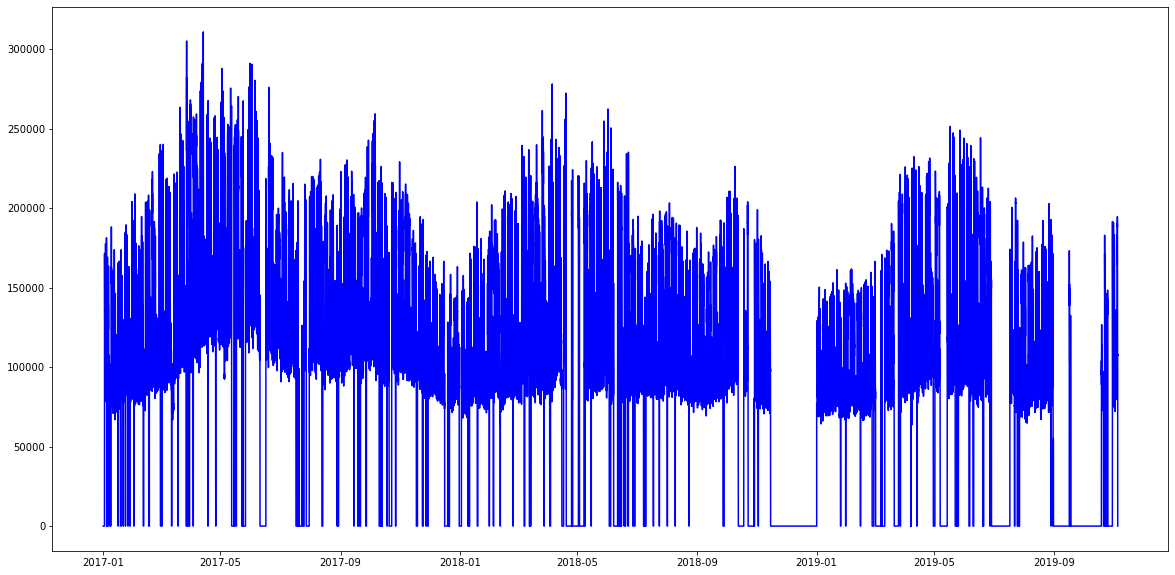

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(df['consumption'].fillna(0), color='blue')

In [4]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [7]:
def dtw(x, y, dist, warp=1, w=inf, s=1.0):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M arrayNot only do you need normalisation, but you should apply the exact same scaling as for your training data. That means storing the scale and offset used with your training data, and using that again. A common beginner mistake is to separately normalise your train and test data.
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    :param int w: window size limiting the maximal distance between indices of matched entries |i,j|.
    :param float s: weight applied on off-diagonal moves of the path. As s gets larger, the warping path is increasingly biased towards the diagonal
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not isinf(w):
        D0 = full((r + 1, c + 1), inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = zeros((r + 1, c + 1))
        D0[0, 1:] = inf
        D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist(i, j, x, y)
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r)
                j_k = min(j + k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

In [8]:
def derivative_dtw_distance(i, j, x, y):
    if i+1 == len(x) or j+1 == len(y):
        dist = (x[i] - y[j])**2
    
    else:
        d_x_i = ((x[i] - x[i-1]) + (x[i+1] - x[i-1])/2)/2
        d_y_j = ((y[j] - y[j-1]) + (y[j+1] - y[j-1])/2)/2    

        dist = (d_x_i - d_y_j)**2

    return dist

In [9]:
def dtwbi(D, Q, len_gap, stride=20):
	
	min_dtw_cost = inf
	start_index = 0
	
	for i in range(0, len(D)-len_gap, stride):
		#print(i, i+len_gap)
		try:
			cost, cost_matrix, acc_cost_matrix, path = dtw(D[i:i+len_gap], Q, dist=derivative_dtw_distance)
		except:
			print(D[i*len_gap:(i+1)*len_gap])
			print('Q', Q)
			print('len_gap', len_gap)
			print('len(D)', len(D))
			print(i*len_gap, (i+1)*len_gap)
			raise
		if cost < min_dtw_cost:
			min_dtw_cost = cost
			start_index=i

	return start_index

In [10]:
def apply_dtwbi_after(x, start_index, end_index, span=4*24*7*4): # span = 1 month
	len_gap = end_index - start_index
	
	Qa = x[end_index:end_index+len_gap]
	Da = x[end_index+len_gap:end_index+len_gap+span]
	
	Qas_start = dtwbi(Da, Qa, len_gap)
	#Qas = x[Qas_start:Qas_start+len_gap]
	
	if Qas_start-len_gap < 0:
		refA = x[Qas_start:Qas_start+len_gap] # = Qa
	else:
		refA = x[Qas_start-len_gap:Qas_start] # Previous window of Qas

	return refA

In [11]:
def apply_dtwbi_before(x, start_index, end_index, span=4*24*7*4): # span = 1 month
	len_gap = end_index - start_index
	
	Qb = x[start_index-len_gap:start_index]
	Db = x[start_index-len_gap-span:start_index-len_gap]
	
	if len(Qb) == 0:
		print('start_index', start_index)
		print('len_gap', len_gap)
		print('end_index', end_index)
		raise

	Qbs_start = dtwbi(Db, Qb, len_gap)
	#Qbs = x[Qbs_start:Qbs_start+len_gap]
	
	if Qbs_start+2*len_gap > len(x):
		refB = x[Qbs_start:Qbs_start+len_gap] # = Qb
	
	else:
		refB = x[Qbs_start+len_gap:Qbs_start+2*len_gap] # Next window of Qbs

	return refB

In [12]:
def edtwbi(x, start_index, end_index):
	len_gap = end_index - start_index
	
	if end_index + len_gap >= len(x):
		refB = apply_dtwbi_before(x, start_index, end_index) # only dtwbi in other direction
		
		return refB
		
	elif start_index-len_gap <= 0:
		refA = apply_dtwbi_after(x, start_index, end_index) # only dtwbi in other direction
		
		return refA
	
	else: # both cannot simultaneously happen, so not keeping a case for that
		refA = apply_dtwbi_after(x, start_index, end_index)
		refB = apply_dtwbi_before(x, start_index, end_index)
		
		return np.mean([np.array(refA), np.array(refB)], axis = 0)

In [13]:
def find_gaps(x):
    seq = False
    missing_seqs = []
    seq_start_idx = -1
    for i in range(len(x)):
        if seq == False and x[i] == 0:
            seq = True
            seq_start_idx = i
        
        elif seq == True and x[i] != 0:
            seq = False
            if seq_start_idx == -1:
                raise
            missing_seqs.append((seq_start_idx, i))
            seq_start_idx = -1
    
    return missing_seqs

In [14]:
row = df.fillna(value=0)['consumption'].to_list()
row_filled = row.copy()
gaps = find_gaps(row)

In [20]:
for gap in tqdm(gaps, total=len(gaps)):
    if gap[1] - gap[0] < 0.3*len(row):
        row_filled[gap[0]:gap[1]] = edtwbi(row, gap[0], gap[1])

100%|██████████| 154/154 [52:43<00:00, 20.54s/it]


In [21]:
with open('missing_value_analysis/edtwbi_imputed.pkl', 'wb') as f:
    pickle.dump(row_filled, f)

In [23]:
len(row_filled)

99649

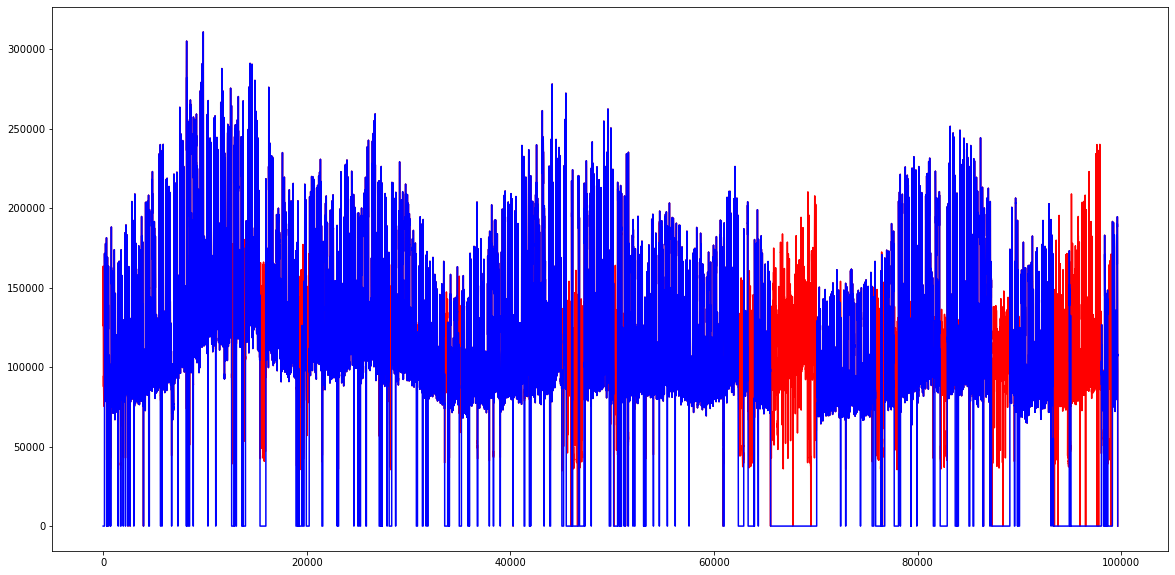

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(row_filled, color='red')
plt.plot(df['consumption'].fillna(0).reset_index(drop=True), color='blue')

In [31]:
test_sample = df['consumption'].iloc[16000:18000]#.reset_index(drop=True)
test_sample

time
2017-06-16 16:00:00    149114.085000
2017-06-16 16:15:00    155648.104667
2017-06-16 16:30:00    158708.776667
2017-06-16 16:45:00    155272.784667
2017-06-16 17:00:00    155539.270667
                           ...      
2017-07-07 10:45:00    190118.154000
2017-07-07 11:00:00    188172.823333
2017-07-07 11:15:00    186900.592667
2017-07-07 11:30:00    183718.716000
2017-07-07 11:45:00    182221.864286
Name: consumption, Length: 2000, dtype: float64

In [32]:
start = np.random.randint(low=0, high=len(test_sample)-500)
test_sample_masked = test_sample.copy()
test_sample_masked[start:start+500] = None

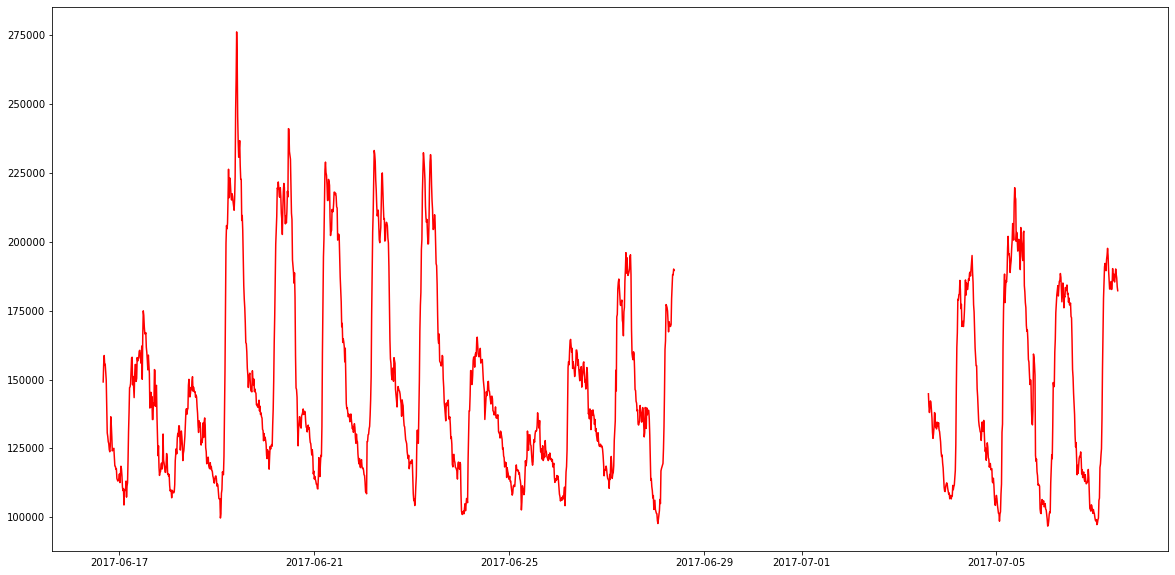

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(test_sample_masked, color='red')
#plt.plot(test_sample, color='blue')

In [38]:
row = test_sample_masked.fillna(0).to_list()
row_filled = row.copy()
gaps = find_gaps(row)

In [40]:
for gap in tqdm(gaps, total=len(gaps)):
    if gap[1] - gap[0] < 0.3*len(row):
        row_filled[gap[0]:gap[1]] = edtwbi(row, gap[0], gap[1])

100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


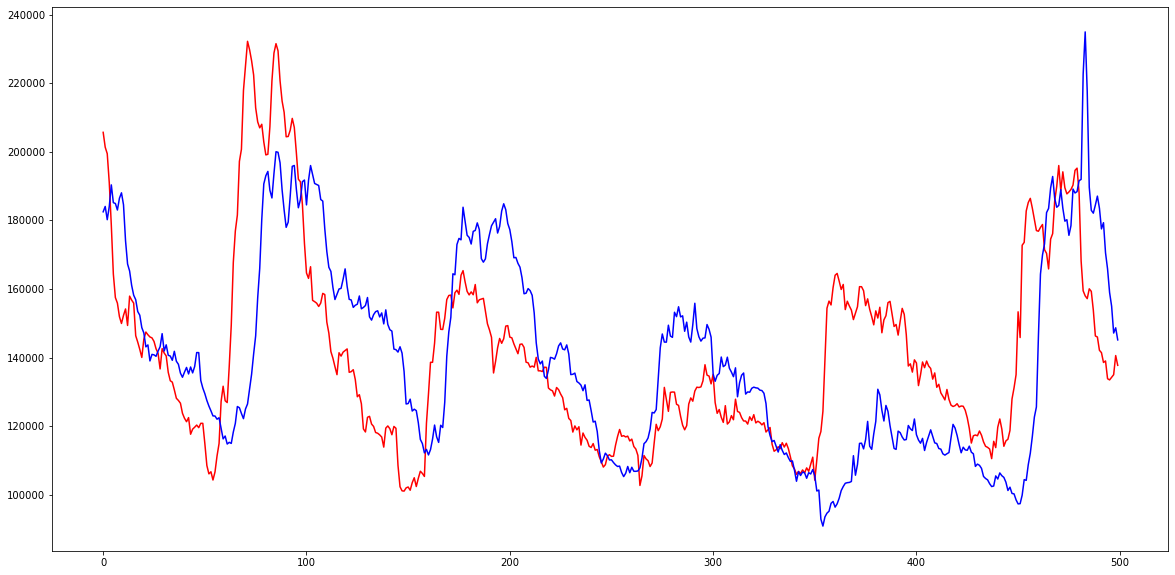

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(row_filled[start:start+500], color='red')
#plt.plot(test_sample_masked.to_list()[1000:1750], color='blue')
plt.plot(test_sample.to_list()[start:start+500], color='blue')

In [57]:
actual = test_sample.to_list()[start:start+500]
pred = row_filled[start:start+500]

In [83]:
# MSE
mean_squared_error(pred, actual, squared=False)

27597.146961110117

In [81]:
# Cosine Similarity
np.dot(pred, actual)/(np.linalg.norm(pred)*np.linalg.norm(actual))

0.9814950289642783

In [88]:
# NMSE
mean_squared_error(pred, actual, squared=False)/(np.std(pred)**2)

3.501603614534521e-05

In [95]:
# Fractional Bias
np.mean((2*np.array(pred) - 2*np.array(actual))/(np.array(pred) + np.array(actual)))

0.0072874949651211334

In [145]:
f = interpolate.interp1d([i for i in range(start)]+[i for i in range(start+500, len(test_sample_masked))], test_sample_masked.dropna())

In [146]:
pred_interp = f([i for i in range(start, start+500)])

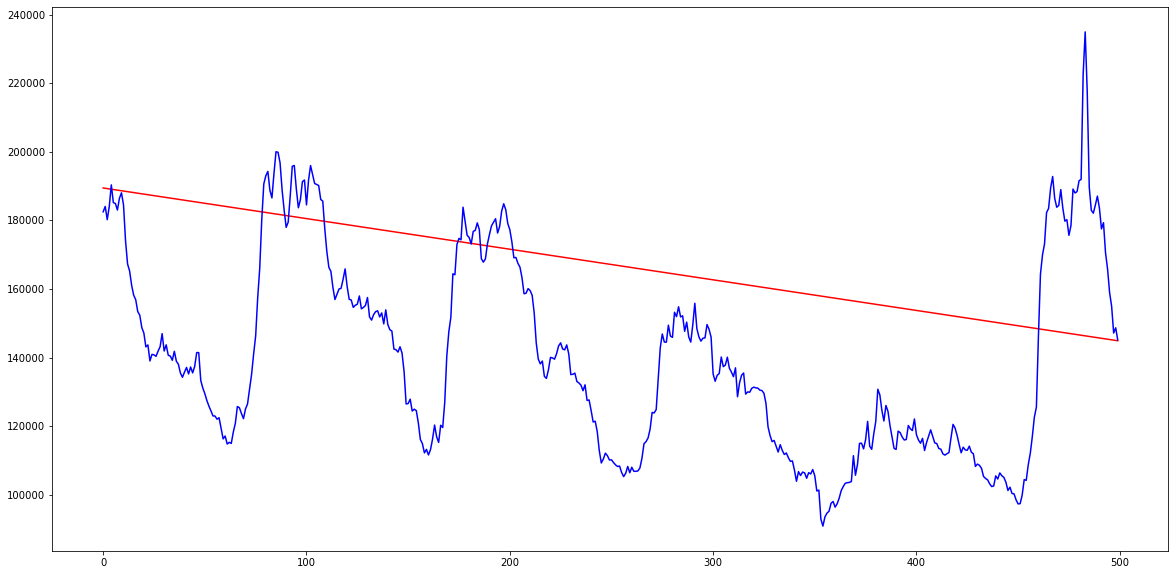

In [147]:
plt.figure(figsize=(20, 10))
plt.plot(pred_interp, color='red')
plt.plot(actual, color='blue')

In [120]:
# MSE
mean_squared_error(pred_interp, actual, squared=False)

38615.75384792969

In [121]:
# Cosine Similarity
np.dot(pred_interp, actual)/(np.linalg.norm(pred_interp)*np.linalg.norm(actual))

0.9815120540461404

In [122]:
# NMSE
mean_squared_error(pred_interp, actual, squared=False)/(np.std(pred_interp)**2)

0.00023227473942371204

In [123]:
# Fractional Bias
np.mean((2*np.array(pred_interp) - 2*np.array(actual))/(np.array(pred_interp) + np.array(actual)))

0.19175201292118793

In [156]:
f = interpolate.CubicSpline([i for i in range(start)]+[i for i in range(start+500, len(test_sample_masked))], test_sample_masked.dropna())

In [158]:
pred_cubic_spline = f([i for i in range(start, start+510)])

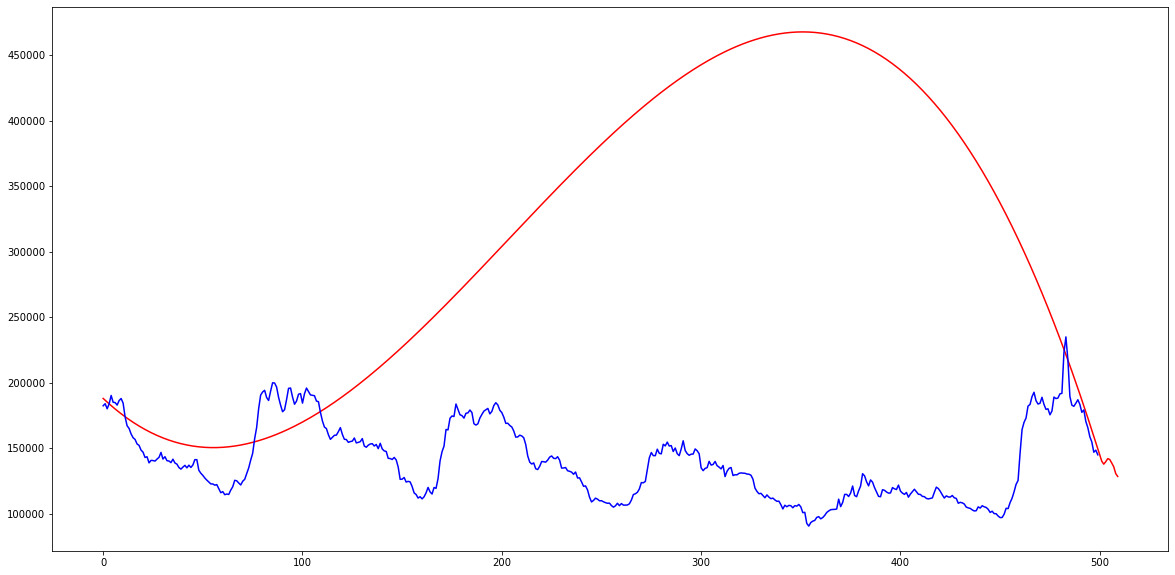

In [159]:
plt.figure(figsize=(20, 10))
plt.plot(pred_cubic_spline, color='red')
plt.plot(actual, color='blue')